# Choosing a Training Set

We have a few possible options for what data to use to train our machine learning model. Given that we have already evaluated ~90k different quaternary Heusler (QH) compounds, we could certainly train a machine learning model on just QH data. 
Using only QH data means that our taining set is focused on the kinds of predictions we want to make (stability of QHs), but we could also supplement the dataset with data regarding other types of compounds.
While adding in data from the rest of the OQMD increases our training set size, it might also introduce a lot of data that is irrelevent to predicting the properties of Heuslers.
Or, there is a third option: training the model on both QHs and similar, ternary Heusler compounds.
In this notebook, we attempt to determine which training set is the best choice.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import kendalltau, bayes_mvs
import numpy as np
import pandas as pd
import json
import os

Key variables

In [2]:
n_repeats = 5 # Number of times you repeat the CV test
n_steps = 8 # Number of sizes of QH dataset to use for training set
test_fraction = 0.1 # Fraction of QH dataset to withhold as test set

## Load in the Data
Read in the data from JSON to get the training and test sets

In [3]:
def load_data(path):
    """Read in a JSON file from disk, and return the inputs and outputs"""
    
    temp = json.load(open(path))
    X = np.array([x['attributes'] for x in temp['entries']], dtype=np.float32)
    y = np.array([x['class']['measured'] for x in temp['entries']], dtype=np.float32)
    return X, y

Load in the Quaternary Heusler dataset

In [4]:
qh_X, qh_y = load_data(os.path.join('..', 'datasets', 'quat-heuslers.json'))
print('Read in %d QH entries'%len(qh_X))

Read in 96188 QH entries


Load in the ternary Heusler dataset

In [5]:
th_X, th_y = load_data(os.path.join('..', 'datasets', 'heuslers.json'))
print('Read in %d ternary Heusler entries'%len(th_X))

Read in 184094 ternary Heusler entries


Load in everything else from the OQMD

In [6]:
oqmd_X, oqmd_y = load_data(os.path.join('..', 'datasets', 'oqmd-no-heusler.json'))
print('Read in %d entries from the rest of the OQMD'%len(oqmd_X))

Read in 145866 entries from the rest of the OQMD


## Run the Test
Our test is basically a random split cross-validation test. We first split off a chunk of the QH dataset to use as a test set. Then, we train a model on progressively larger amounts of the remainding data and measure the model performance. The unique part of this test is we measure the effect of adding different datasets (e.g., the TH and OQMD datasets) 

In [7]:
model = Pipeline([
    ('imputer', Imputer()),
    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1)),
])

In [8]:
test_size = int(test_fraction * len(qh_X))

In [ ]:
def run_test(train_X, train_Y, test_X, test_Y, label, qh_size):
    model.fit(train_X, train_Y)
    pred_Y = model.predict(test_X)
    R = metrics.r2_score(test_Y, pred_Y)
    MAE = metrics.mean_absolute_error(test_Y, pred_Y)
    MSE = metrics.mean_squared_error(test_Y, pred_Y)
    tau = kendalltau(test_Y, pred_Y)
    return {'label': label, 'qh_size': qh_size, 'R2': R, 
            'MAE': MAE, 'MSE': MSE, 'tau': tau.correlation}

In [ ]:
results = [] # Holds dictionaries with each result

In [ ]:
for rep in tqdm(range(n_repeats), desc='Repeat'):
    # Get a new test set from the QH compounds, store remainder as train
    pool_X, test_X, pool_Y, test_Y = train_test_split(qh_X, qh_y, test_size=test_size)

    # Gradually increase size of training set
    for qh_size in tqdm(np.logspace(0, np.log10(len(pool_X)), n_steps, dtype=np.int), desc='Size', leave=False):
        # Randomly draw entries from the pool of data to serve as a training set
        train_X, _, train_Y, _ = train_test_split(pool_X, pool_Y, train_size=qh_size)
        
        # Train a model using only the QH data
        results.append(run_test(train_X, train_Y, test_X, test_Y, 'QH', qh_size))
        
        # Train a model using the QH+TH data
        train_X = np.vstack([train_X, th_X])
        train_Y = np.concatenate([train_Y, th_y])
        results.append(run_test(train_X, train_Y, test_X, test_Y, 'QH+TH', qh_size))
        
        # Run and score it
        train_X = np.vstack([train_X, oqmd_X])
        train_Y = np.concatenate([train_Y, oqmd_y])
        results.append(run_test(train_X, train_Y, test_X, test_Y, 'All OQMD', qh_size))

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


/home/wardlt/software/scikit-learn/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/wardlt/software/scikit-learn/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/wardlt/software/scikit-learn/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/wardlt/software/scikit-learn/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/wardlt/software/scikit-learn/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/wardlt/so

In [14]:
test_results = pd.DataFrame(results)

In [50]:
test_results.to_csv('test_results.csv', index=False)

In [21]:
test_results['tau'][0].correlation

nan

## Analyze the Results
First determine confidence intervals, and then plot the accuracy as a function of training set size

In [30]:
test_results['tau'] = test_results['tau'].apply(lambda x: x.correlation)

In [33]:
results_with_ci = []
for (label, qh_size), group in test_results.groupby(['label', 'qh_size']):
    row = {'label': label, 'qh_size': qh_size}
    for stat in ['MAE', 'MSE', 'R2', 'tau']:
        mean, _, _ = bayes_mvs(group[stat], alpha=0.95)
        row[stat] = mean[0]
        row['%s_ci'%stat] = np.mean(np.abs(mean[1] - mean[0]))
    results_with_ci.append(row)
results_with_ci = pd.DataFrame(results_with_ci)

In [51]:
results_with_ci.to_csv('test_results_with_ci.csv', index=False)

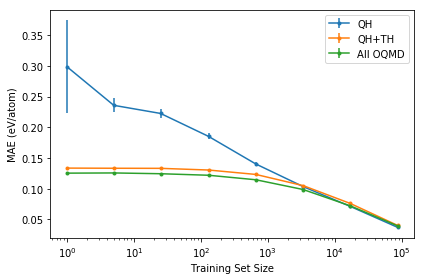

In [44]:
fig, ax = plt.subplots()

for g in ['QH', 'QH+TH', 'All OQMD']:
    group = results_with_ci.query('label == "%s"'%g)
    ax.errorbar(group['qh_size'], group['MAE'], label=g, yerr=group['MAE_ci'], marker='o', ms=3)
    
ax.set_xscale('log')

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('MAE (eV/atom)')

fig.tight_layout()
fig.savefig('mae_plot.png', dpi=320)
fig.savefig('mae_plot.pdf')

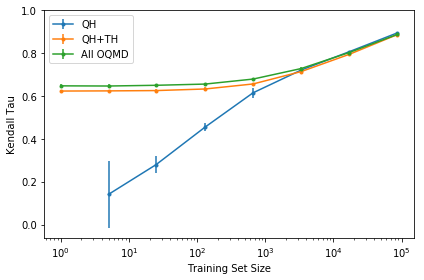

In [47]:
fig, ax = plt.subplots()

for g in ['QH', 'QH+TH', 'All OQMD']:
    group = results_with_ci.query('label == "%s"'%g)
    ax.errorbar(group['qh_size'], group['tau'], label=g, yerr=group['tau_ci'], marker='o', ms=3)
    
ax.set_xscale('log')

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Kendall Tau')
ax.set_ylim(min(ax.get_ylim()), 1)

fig.tight_layout()
fig.savefig('tau_plot.png', dpi=320)
fig.savefig('tau_plot.pdf')

*Finding*: Training on the entire OQMD yields the best results for most training set sizes. At the largest training set size (show below), the QH-only model does perform slightly better

In [49]:
results_with_ci.query('qh_size == %d'%max(results_with_ci['qh_size'])).sort_values('MAE')

,MAE,MAE_ci,MSE,MSE_ci,R2,R2_ci,label,qh_size,tau,tau_ci
15,0.037145,0.000494,0.003930,0.000267,0.959599,0.003533,QH,86569,0.894889,0.001031
7,0.039512,0.000251,0.004270,0.000300,0.956100,0.003926,All OQMD,86569,0.887759,0.001253
23,0.040283,0.000346,0.004547,0.000261,0.953269,0.003534,QH+TH,86569,0.886850,0.000834
